# Hi! Welcome to my kernel.

In this notebook, we'll use a deep learning model based on Keras and a lot of data cleaning/ preprocessing for toxicity classification of comments.

**Contents**

- <a href='#1'>1. Import the necessary libraries</a>

- <a href='#2'>2. Read the dataset</a>

- <a href='#3'>3. Embeddings</a>

- <a href='#4'>4. Text Preprocessing</a>
   
- <a href='#5'>5. Model Architecture</a>
     
- <a href='#6'>6. Model Tuning</a>
     
- <a href='#7'>7. Model Training and Prediction</a>
     
     
    
    

 

<a id='1'>1. Import the necessary libraries</a>

In [1]:
import gc
import re
import operator 

import numpy as np
import pandas as pd

from gensim.models import KeyedVectors

from sklearn import model_selection


import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,  Callback, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


<a id='2'>2. Read the dataset</a>

In [2]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

Let's take a glimplse of the data

In [3]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


We have 13GB of RAM available. So to utilise it completely, I will reduce the size of the data.

In [4]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [5]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 619.6543884277344  MB
******************************
Column:  id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  target
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  severe_toxicity
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  obscene
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  identity_attack
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  insult
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  threat
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  asian
dtype before:  fl

We have reduced the Memory usage to  294.33 MB which is 47.50000646397767 % of the initial size

In [6]:
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)



Train shape :  (1804874, 45)
Test shape :  (97320, 2)


In [7]:
df = pd.concat([train[['id','comment_text']], test], axis=0)
del(train, test)
gc.collect()

25

<a id='3'>3. Embeddings</a>

To start we'll just take the FastText Common Crawl embeddings.

In [8]:
ft_common_crawl = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
embeddings_index = KeyedVectors.load_word2vec_format(ft_common_crawl)

<a id='4'>4. Text Preprocessing</a>

Here we will try to clean our data as much as possible, to map as much words to embeddings.

In [9]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [10]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

Firstly we will convert all out words to lower case.

In [11]:
df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())

In [12]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
oov[:15]

Found embeddings for 12.870% of vocab
Found embeddings for  91.201% of all text


[("i'm", 87786),
 ("i've", 28451),
 ('"the', 26467),
 ("trump's", 25755),
 ("let's", 24190),
 ("aren't", 22808),
 ("wouldn't", 22241),
 ('so,', 21391),
 ("wasn't", 20224),
 ("i'd", 19329),
 ("what's", 18156),
 ('no,', 17856),
 ('trump.', 17578),
 ("i'll", 17189),
 ('it?', 12995)]

The first hurdle we get is contaction. Our next step is to clean the contractions in the text

In [13]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                       "he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have",
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not",
                       "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as", "this's": "this is",
                       "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", 
                       "they've": "they have", "to've": "to have", "wasn't": "was not",
                       "we'd": "we would", "we'd've": "we would have", "we'll": 
                       "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", 
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                       "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [14]:
del(vocab,oov)

In [15]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [16]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [17]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
oov[:10]

Found embeddings for 12.945% of vocab
Found embeddings for  91.708% of all text


[("trump's", 28503),
 ('"the', 26467),
 ('so,', 21391),
 ('no,', 17856),
 ('trump.', 17578),
 ('it?', 12995),
 ('trump,', 11879),
 ('but,', 10540),
 ('fact,', 10043),
 ('"i', 9931)]

Now it's time for punctuations

In [18]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [19]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [20]:
print(unknown_punct(embeddings_index, punct))

_ ` 


In [21]:
punct_mapping = {"_":" ", "`":" "}

def clean_special_chars(text, puncts, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])    
    for p in puncts:
        text = text.replace(p, f' {p} ')     
    return text


In [22]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [23]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)

Found embeddings for 47.128% of vocab
Found embeddings for  99.520% of all text


In [24]:
oov[:20]

[('khadr', 6316),
 ('murkowski', 3601),
 ('siemian', 2178),
 ('sb21', 1986),
 ('mulroney', 1941),
 ('chretien', 1863),
 ('notley', 1708),
 ('theglobeandmail', 1423),
 ('manafort', 1417),
 ('djou', 1290),
 ('gorsuch', 1214),
 ('alceste', 1169),
 ('albertans', 1168),
 ('horgan', 1089),
 ('begich', 1057),
 ('sloter', 1034),
 ('usccb', 1015),
 ('gabbard', 1003),
 ('kealoha', 962),
 ('tfsa', 959)]

Fianlly, we have to clean the numbers.

In [25]:
def clean_numbers(x):
    return re.sub('\d+', ' ', x)
df['comment_text'] = df['comment_text'].apply(clean_numbers)
df['comment_text'] = df['comment_text'].apply(clean_numbers)

In [26]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
oov[:20]

Found embeddings for 48.153% of vocab
Found embeddings for  99.546% of all text


[('khadr', 6316),
 ('murkowski', 3601),
 ('siemian', 2178),
 ('mulroney', 1942),
 ('chretien', 1863),
 ('notley', 1708),
 ('theglobeandmail', 1423),
 ('manafort', 1417),
 ('djou', 1291),
 ('gorsuch', 1214),
 ('alceste', 1169),
 ('albertans', 1168),
 ('horgan', 1089),
 ('begich', 1057),
 ('sloter', 1034),
 ('usccb', 1015),
 ('gabbard', 1003),
 ('kealoha', 962),
 ('tfsa', 959),
 ('kpmg', 949)]

In [27]:
del(vocab,oov)
gc.collect()

0

Now, we split the data.

In [28]:
train = df.iloc[:1804874,:]
test = df.iloc[1804874:,:]

train.head()

,id,comment_text
0,59848,"this is so cool . it is like , ' would yo..."
1,59849,thank you ! ! this would make my life a lot ...
2,59852,this is such an urgent design problem ; kudos...
3,59855,is this something i will be able to install on...
4,59856,haha you guys are a bunch of losers .


Let's see a wordcloud of what we are dealing with.

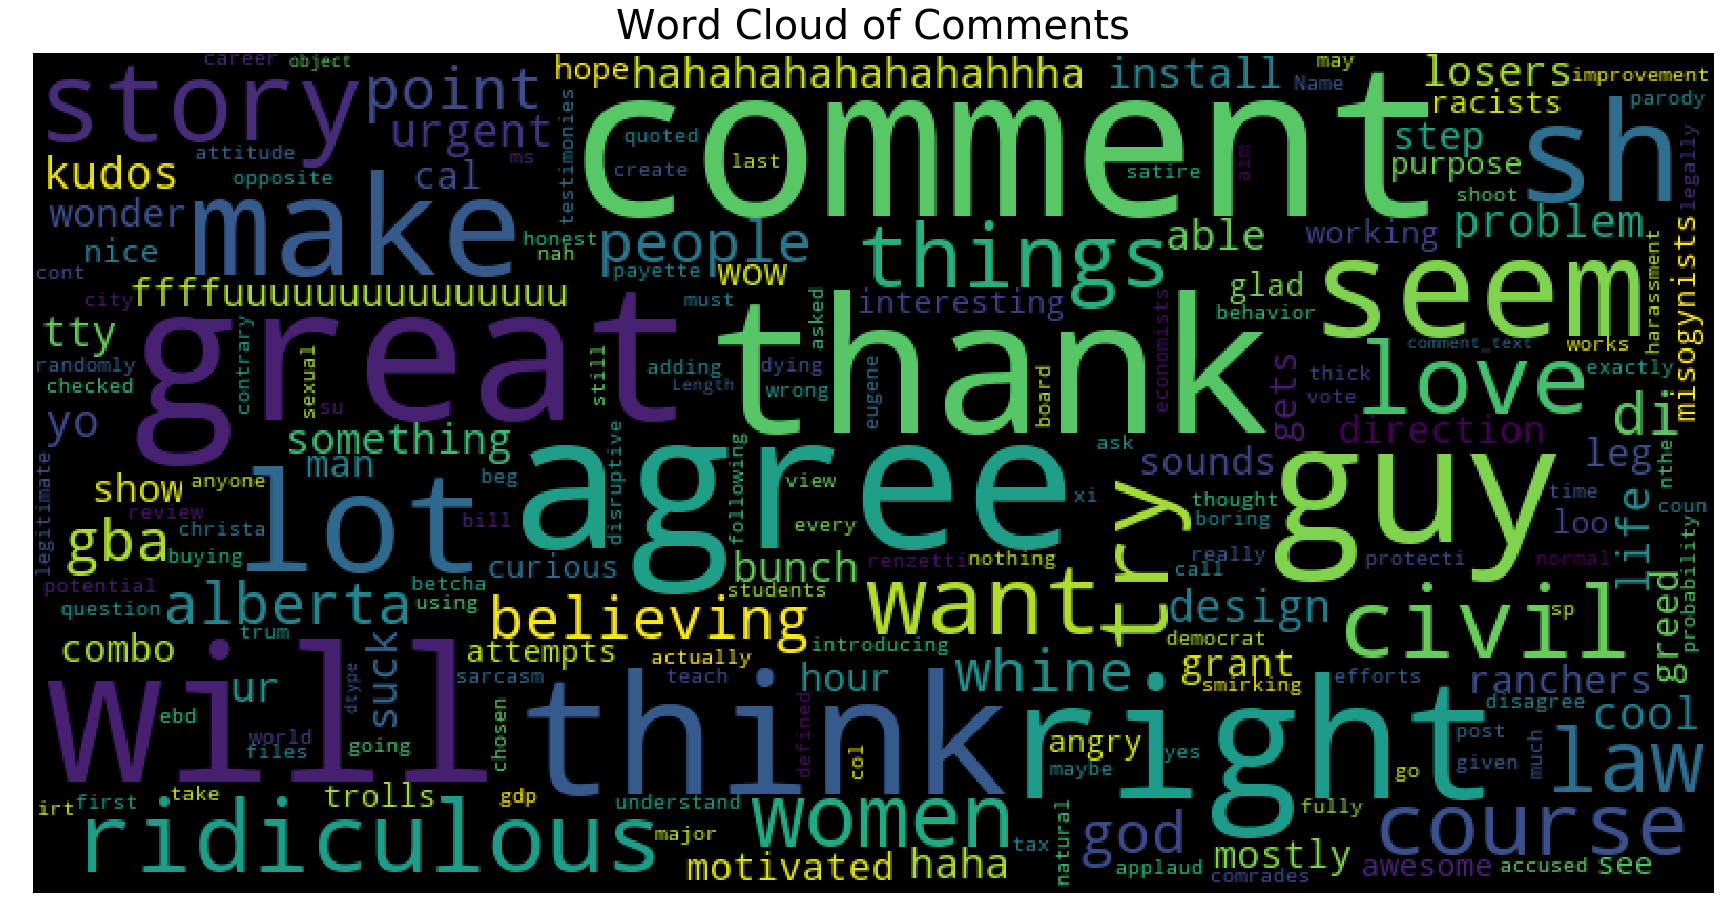

In [29]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["comment_text"], title="Word Cloud of Comments")

In [30]:
train_orig = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
train = pd.concat([train,train_orig[['target']]],axis=1)
del(train_orig)
gc.collect()
train['target'] = np.where(train['target'] >= 0.5, True, False)

In [31]:
train.head()

,id,comment_text,target
0,59848,"this is so cool . it is like , ' would yo...",False
1,59849,thank you ! ! this would make my life a lot ...,False
2,59852,this is such an urgent design problem ; kudos...,False
3,59855,is this something i will be able to install on...,False
4,59856,haha you guys are a bunch of losers .,True


<a id='5'>5. Model Training</a>

Splitting the data

In [32]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.1)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

1624386 train comments, 180488 validate comments


In [33]:
del train

In [34]:
MAX_NUM_WORDS = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 256
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)


In [35]:
EMBEDDINGS_DIMENSION = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,EMBEDDINGS_DIMENSION))

In [36]:
num_words_in_embedding = 0

for word, i in tokenizer.word_index.items():
    if word in embeddings_index.vocab:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector        
        num_words_in_embedding += 1

In [37]:
train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
train_labels = train_df[TOXICITY_COLUMN]
validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
validate_labels = validate_df[TOXICITY_COLUMN]

<a id='5'>5. Model Architecture</a>

Our model architecture is defined in the **build_model** function.



In [38]:
def build_model(lr=0.0, lr_d=0.0, units=64, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=0, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDINGS_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
    x = embedding_layer(sequence_input)
    x = SpatialDropout1D(spatial_dr)(x)
    x = Bidirectional(CuDNNGRU(units, return_sequences=True))(x)   
    x = Conv1D(conv_size, kernel_size2, padding = "valid", kernel_initializer = "he_uniform")(x)
  

    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)     
    
    x = concatenate([avg_pool1, max_pool1])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x)
    
    preds = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs = sequence_input, outputs = preds)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(train_text, train_labels, batch_size = 1024, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
   
    model = load_model(file_path)
    return model

SyntaxError: invalid syntax (<ipython-input-38-1e5bad2763ee>, line 26)

*Time for training!*

<a id='6'>6. Model Tuning</a>

In this section I have tried to find the optimum number of filters for the GRU, Dense and the conv1D as well the the ideal percentage of dropouts. Since the kernel was taking a long time to run, I have commented the code and shared the results in the below tables.

**GRU**

In [39]:
#unit_list=[8, 16, 32, 64]
#for u in unit_list:
#    Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = u, spatial_dr = 0.3, kernel_size1=4, kernel_size2=2, dense_units=32, dr=0.1, conv_size=64, epochs=5)

<table>
<tbody>
<tr>
<td colspan="5" width="638">
<p><strong>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;GRU</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p><strong># Layers</strong></p>
</td>
<td width="129">
<p><strong>Train Acc</strong></p>
</td>
<td width="129">
<p><strong>Train Loss</strong></p>
</td>
<td width="123">
<p><strong>Val Acc</strong></p>
</td>
<td width="129">
<p><strong>Val Loss</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p>8</p>
</td>
<td width="129">
<p>0.9494</p>
</td>
<td width="129">
<p>0.1287</p>
</td>
<td width="123">
<p>0.9509</p>
</td>
<td width="129">
<p>0.1230</p>
</td>
</tr>
<tr>
<td width="129">
<p>16</p>
</td>
<td width="129">
<p>0.9507</p>
</td>
<td width="129">
<p>0.1246</p>
</td>
<td width="123">
<p>0.9512</p>
</td>
<td width="129">
<p>0.1229</p>
</td>
</tr>
<tr>
<td width="129">
<p>32</p>
</td>
<td width="129">
<p>0.9515</p>
</td>
<td width="129">
<p>0.1215</p>
</td>
<td width="123">
<p>0.9488</p>
</td>
<td width="129">
<p>0.1248</p>
</td>
</tr>
<tr>
<td width="129">
<p>64</p>
</td>
<td width="129">
<p>0.9517</p>
</td>
<td width="129">
<p>0.1213</p>
</td>
<td width="123">
<p>0.9520</p>
</td>
<td width="129">
<p>0.1201</p>
</td>
</tr>
</tbody>
</table>

**Dense Layers**

In [40]:
#dense_list=[16, 32, 64]
#for d in dense_list:
#    Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=4, kernel_size2=2, dense_units=d, dr=0.1, conv_size=64, epochs=5)

<table>
<tbody>
<tr>
<td colspan="5" width="638">
<p><strong>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Dense</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p><strong># Layers</strong></p>
</td>
<td width="129">
<p><strong>Train Acc</strong></p>
</td>
<td width="129">
<p><strong>Train Loss</strong></p>
</td>
<td width="123">
<p><strong>Val Acc</strong></p>
</td>
<td width="129">
<p><strong>Val Loss</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p>16</p>
</td>
<td width="129">
<p>0.9512</p>
</td>
<td width="129">
<p>0.1229</p>
</td>
<td width="123">
<p>0.9515</p>
</td>
<td width="129">
<p>0.1227</p>
</td>
</tr>
<tr>
<td width="129">
<p>32</p>
</td>
<td width="129">
<p>0.9517</p>
</td>
<td width="129">
<p>0.1213</p>
</td>
<td width="123">
<p>0.9519</p>
</td>
<td width="129">
<p>0.1195</p>
</td>
</tr>
<tr>
<td width="129">
<p>64</p>
</td>
<td width="129">
<p>0.9526</p>
</td>
<td width="129">
<p>0.1183</p>
</td>
<td width="123">
<p>0.9519</p>
</td>
<td width="129">
<p>0.1199</p>
</td>
</tr>
</tbody>
</table>

**Conv1d Layers**

In [41]:
#conv_list=[32, 64, 128]
#for c in conv_list:
#    Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=4, kernel_size2=2, dense_units=64, dr=0.1, conv_size=c, epochs=5)

<table>
<tbody>
<tr>
<td colspan="5" width="638">
<p><strong>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Conv1d</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p><strong># Layers</strong></p>
</td>
<td width="129">
<p><strong>Train Acc</strong></p>
</td>
<td width="129">
<p><strong>Train Loss</strong></p>
</td>
<td width="123">
<p><strong>Val Acc</strong></p>
</td>
<td width="129">
<p><strong>Val Loss</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p>32</p>
</td>
<td width="129">
<p>0.9525</p>
</td>
<td width="129">
<p>0.1189</p>
</td>
<td width="123">
<p>0.9515</p>
</td>
<td width="129">
<p>0.1188</p>
</td>
</tr>
<tr>
<td width="129">
<p>64</p>
</td>
<td width="129">
<p>0.9524</p>
</td>
<td width="129">
<p>0.1191</p>
</td>
<td width="123">
<p>0.9535</p>
</td>
<td width="129">
<p>0.1172</p>
</td>
</tr>
<tr>
<td width="129">
<p>128</p>
</td>
<td width="129">
<p>0.9518</p>
</td>
<td width="129">
<p>0.1213</p>
</td>
<td width="123">
<p>0.9533</p>
</td>
<td width="129">
<p>0.1158</p>
</td>
</tr>
</tbody>
</table>

**Spacial Dropout**

In [42]:
#spdr_list=[0.2, 0.3, 0.4]
#for s in spdr_list:
#    Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = s, kernel_size1=4, kernel_size2=2, dense_units=64, dr=0.1, conv_size=128, epochs=5)

<table>
<tbody>
<tr>
<td colspan="5" width="638">
<p><strong>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;Spacial Droupout</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p><strong>#&nbsp;</strong></p>
</td>
<td width="129">
<p><strong>Train Acc</strong></p>
</td>
<td width="129">
<p><strong>Train Loss</strong></p>
</td>
<td width="123">
<p><strong>Val Acc</strong></p>
</td>
<td width="129">
<p><strong>Val Loss</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p>0.2</p>
</td>
<td width="129">
<p>0.9525</p>
</td>
<td width="129">
<p>0.1186</p>
</td>
<td width="123">
<p>0.9533</p>
</td>
<td width="129">
<p>0.1163</p>
</td>
</tr>
<tr>
<td width="129">
<p>0.3</p>
</td>
<td width="129">
<p>0.9515</p>
</td>
<td width="129">
<p>0.1217</p>
</td>
<td width="123">
<p>0.9529</p>
</td>
<td width="129">
<p>0.1181</p>
</td>
</tr>
<tr>
<td width="129">
<p>0.4</p>
</td>
<td width="129">
<p>0.9502</p>
</td>
<td width="129">
<p>0.1265</p>
</td>
<td width="123">
<p>0.9513</p>
</td>
<td width="129">
<p>0.1229</p>
</td>
</tr>
</tbody>
</table>

**Dropout**

In [43]:
#dr_list=[0, 0.1, 0.2]
#for i in dr_list:
#    Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=4, kernel_size2=2, dense_units=64, dr= i, conv_size=128, epochs=5)

<table>
<tbody>
<tr>
<td colspan="5" width="638">
<p><strong>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Dropout</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p><strong>#</strong></p>
</td>
<td width="129">
<p><strong>Train Acc</strong></p>
</td>
<td width="129">
<p><strong>Train Loss</strong></p>
</td>
<td width="123">
<p><strong>Val Acc</strong></p>
</td>
<td width="129">
<p><strong>Val Loss</strong></p>
</td>
</tr>
<tr>
<td width="129">
<p>0</p>
</td>
<td width="129">
<p>0.9521</p>
</td>
<td width="129">
<p>0.1202</p>
</td>
<td width="123">
<p>0.9514</p>
</td>
<td width="129">
<p>0.1184</p>
</td>
</tr>
<tr>
<td width="129">
<p>0.1</p>
</td>
<td width="129">
<p>0.9508</p>
</td>
<td width="129">
<p>0.1244</p>
</td>
<td width="123">
<p>0.9437</p>
</td>
<td width="129">
<p>0.1493</p>
</td>
</tr>
<tr>
<td width="129">
<p>0.2</p>
</td>
<td width="129">
<p>0.9372</p>
</td>
<td width="129">
<p>0.1664</p>
</td>
<td width="123">
<p>0.9473</p>
</td>
<td width="129">
<p>0.1399</p>
</td>
</tr>
</tbody>
</table>

<a id='7'>7. Model training and Prediction</a>

 Model1= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.2, kernel_size1=4, kernel_size2=2, dense_units=32, dr=0, conv_size=128, epochs=10)

submission1 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission1['prediction'] = Model1.predict(pad_text(test[TEXT_COLUMN], tokenizer))
submission1.reset_index(drop=False, inplace=True)
submission1.head()
submission1.to_csv('submission1.csv', index=False)

In [44]:
 Model2= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.2, kernel_size1=4, kernel_size2=2, dense_units=64, dr=0, conv_size=64, epochs=10)

NameError: name 'build_model' is not defined

In [45]:
submission2 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission2['prediction'] = Model2.predict(pad_text(test[TEXT_COLUMN], tokenizer))
submission2.reset_index(drop=False, inplace=True)
submission2.head()
submission2.to_csv('submission.csv', index=False)

NameError: name 'Model2' is not defined

 Model3= build_model(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.2, kernel_size1=4, kernel_size2=2, dense_units=32, dr=0, conv_size=128, epochs=10)

submission3 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission3['prediction'] = Model3.predict(pad_text(test[TEXT_COLUMN], tokenizer))
submission3.reset_index(drop=False, inplace=True)
submission3.head()
submission3.to_csv('submission3.csv', index=False)